- Organize all the data of the coefficients and the covariance
- Compute mean coefficients
- Compute variance
- Compute smoothing
- Compute S/N
- Select coefficients
- Print coefficients


In [1]:
%pylab inline
import biff


Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [3]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10.

In [71]:
## Reading coefficients
def reshape_matrix(matrix, n, l, m):
    col_matrix = np.zeros((n+1, l+1, m+1))


    counter = 0
    for n in range(n+1):
        for l in range(l+1):
            for m in range(0, l+1):
                col_matrix[n][l][m] = matrix[counter]
                counter +=1
    return col_matrix

In [219]:
## Reading coefficients
def read_coeff_matrix(filename, nfiles, n, l, m, nmin=0, nmax=1000):

    S_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    T_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    S_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    T_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))

    for i in range(nmin, nmax+1):
        coeff = np.loadtxt(filename + '{:03d}.txt'.format(i))
        S_matrix[:,i] = coeff[:,0]
        T_matrix[:,i] = coeff[:,1]
        
    for i in range(len(S_matrix[:,0])):
        S_mean[i] = np.mean(S_matrix[i])
        T_mean[i] = np.mean(T_matrix[i])

    S_mean_matrix = reshape_matrix(S_mean, n, l, m)
    T_mean_matrix = reshape_matrix(S_mean, n, l, m)

    return S_mean_matrix, T_mean_matrix

## Reading covariance
def var_matrix(filename, filename2, nfiles, n, l, m, mass, nmin=0, nmax=1000):

    Scov_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    Tcov_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    Svar_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    Tvar_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    
    
    S_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    T_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    for i in range(nmin, nmax+1):
        cov = np.loadtxt(filename + '{:03d}.txt'.format(i))
        coeff = np.loadtxt(filename2 + '{:03d}.txt'.format(i))

        Scov_matrix[:,i] = cov[:,0]
        Tcov_matrix[:,i] = cov[:,1]
        
        S_matrix[:,i] = coeff[:,0]
        T_matrix[:,i] = coeff[:,1]
    

    for i in range(len(Scov_matrix[:,0])):
        Svar_mean[i] = np.mean((Scov_matrix[i] - mass*S_matrix[i]**2))#**2) / nfiles
        Tvar_mean[i] = np.mean((Tcov_matrix[i] - mass*T_matrix[1]**2))#**2) / nfiles

    Svar_mean_matrix = reshape_matrix(Svar_mean, n, l, m)
    Tvar_mean_matrix = reshape_matrix(Tvar_mean, n, l, m)
        
    return Svar_mean_matrix, Tvar_mean_matrix



In [220]:
S_mean, T_mean  = read_coeff_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/coeff_rand_mwlmc5_b1_1E6_', 1000, 20, 20, 20, nmin=0, nmax=999)
Scov_mean, Tcov_mean  = var_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/cov_matrix_rand_mwlmc5_b1_1E6_',
                                        '/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/coeff_rand_mwlmc5_b1_1E6_', 1000, 20, 20, 20, 
                                        mass, nmin=0, nmax=999)

In [221]:
def copy_matrix(M, indices):
    M_new = np.zeros(shape(M))
    for i in range(len(indices[0])):
        M_new[indices[0][i]][indices[1][i]][indices[2][i]] = M[indices[0][i]][indices[1][i]][indices[2][i]]
    return M_new

def smoothing(var_coeff, coeff):
    """
    Coefficients smoothing 
    
    """
    b_nlm = 1/(1 + var_coeff/coeff**2)
    # This line remove nans an put the original values
    b_nlm_values = np.nan_to_num(b_nlm)
    return b_nlm_values

def coefficients_smooth_level(S, T, bs, bt, b_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
 
    bs_cut_index = np.where(bs>b_cut)
    bt_cut_index = np.where(bt>b_cut)
    
    if verb == 1:
        print('N coeff S= ', len(bs_cut_index[0]))
        print('N coeff T= ', len(bt_cut_index[0]))

    S_new = copy_matrix(S, bs_cut_index)
    T_new = copy_matrix(T, bt_cut_index)
    
    return S_new, T_new, len(bs_cut_index[0])

In [222]:
mass =1.5772125152E-6

In [223]:
bS = smoothing(Scov_mean, S_mean)
bT = smoothing(Tcov_mean, T_mean)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [224]:
S_opt, T_opt, Ncoeff = coefficients_smooth_level(S_mean, T_mean, bS, bT, 0.5, verb=1)

N coeff S=  1528
N coeff T=  1806


In [205]:
S1, T1  = read_coeff_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/coeff_rand_mwlmc5_b1_1E6_', 2, 20, 20, 20, nmin=0, nmax=1)
Scov1, Tcov1  = read_cov_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/cov_matrix_rand_mwlmc5_b1_1E6_', 2, 20, 20, 20, nmin=0, nmax=1)

In [206]:
bS1 = smoothing(Scov1, S1)
bT1 = smoothing(Tcov1, T1)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [207]:
S1_opt, T1_opt, Ncoeff = coefficients_smooth_level(S1, T1, bS1, bT1, 0.5, verb=1)

N coeff S=  2428
N coeff T=  2428


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


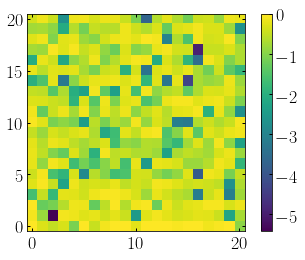

In [225]:
imshow(np.log10(bS[:,:,0]).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


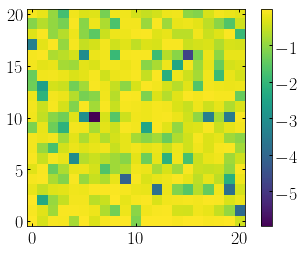

In [226]:
imshow(np.log10(bS1[:,:,0]).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


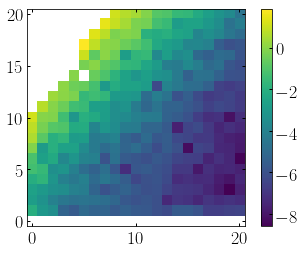

In [218]:
imshow(np.log10(np.abs(bS[:,:,1]*S_opt[:,:,1])).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


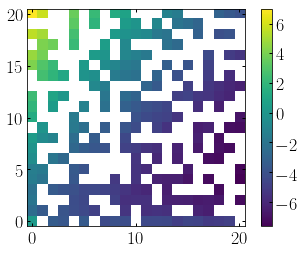

In [217]:
imshow(np.log10(np.abs(S1_opt[:,:,0])).T, origin='lower')
colorbar()